# Data Analytics: Assignment 1
##### by Daphne Lyra Surigao and Kim Andre Mauring
---
This notebook implements a simplified version of the procedures described in *Balanced Risk Set Matching* by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum. Balanced Risk Set Matching is a statistical method used in observational studies to match treated and control subjects while ensuring covariate balance. By pairing patients with similar symptom histories before treatment, this method helps mitigate bias in non-randomized studies. This notebook will generate synthetic patient data, apply risk set matching using Mahalanobis distance, and analyze the quality of matching through visualization techniques.

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore
from scipy.stats import norm

### Step 1: Simulating Patient Data

In [31]:
# Set random seed for reproducibility
np.random.seed(42)

# Initialize number of patients. In this case 400
num_patients = 400

# Create synthetic patient dataset
patient_data = pd.DataFrame({
    'patient_id': np.arange(1, num_patients + 1),
    'entry_time': np.random.randint(0, 12, num_patients),  
    'pain': np.random.randint(0, 10, num_patients),
    'urgency': np.random.randint(0, 10, num_patients),
    'nocturnal_frequency': np.random.randint(0, 10, num_patients),
    'treated': np.random.choice([0, 1], num_patients, p=[0.7, 0.3]),  
    'treatment_time': np.random.randint(3, 24, num_patients) 
})

# Ensure untreated patients have no treatment time
patient_data.loc[patient_data['treated'] == 0, 'treatment_time'] = np.nan

# Display first few rows
patient_data.head()

,patient_id,entry_time,pain,urgency,nocturnal_frequency,treated,treatment_time
0,1,6,0,1,7,0,NaN
1,2,3,8,5,7,1,10.0
2,3,10,5,4,3,0,NaN
3,4,7,6,1,3,0,NaN
4,5,4,9,2,4,0,NaN


### Step 2: Normalizing Data and Computing Mahalanobis Distance

In [32]:
""""
To match patients, we compute Mahalanobis distance, which measures the similarity between patients.
"""

# Normalize symptom data for fair comparison
patient_data[['pain', 'urgency', 'nocturnal_frequency']] = patient_data[['pain', 'urgency', 'nocturnal_frequency']].apply(zscore)

# Compute covariance matrix (for Mahalanobis distance)
cov_matrix = np.cov(patient_data[['pain', 'urgency', 'nocturnal_frequency']].dropna().T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def find_best_match(treated_patient, control_patients):
    """Find the control patient with the minimum Mahalanobis distance to the treated patient."""
    best_match = None
    min_distance = float('inf')
    
    for _, control in control_patients.iterrows():
        distance = mahalanobis(
            treated_patient[['pain', 'urgency', 'nocturnal_frequency']], 
            control[['pain', 'urgency', 'nocturnal_frequency']], 
            inv_cov_matrix
        )
        if distance < min_distance:
            min_distance = distance
            best_match = control

    return best_match

### Step 3: Implementing Risk Set Matching

In [33]:
"""
We iterate through treated patients and find their best-matched control patient.
"""

# Create an empty list for matched pairs
matched_pairs = []

# Iterate through each treated patient
for _, treated in patient_data[patient_data['treated'] == 1].iterrows():
    # Find all eligible controls (not treated before this patient's treatment time)
    eligible_controls = patient_data[(patient_data['treated'] == 0) & 
                                     (patient_data['entry_time'] <= treated['treatment_time'])]
    
    # Find best match based on Mahalanobis distance
    match = find_best_match(treated, eligible_controls)
    
    if match is not None:
        matched_pairs.append((treated['patient_id'], match['patient_id']))

# Convert matched pairs to a DataFrame
matched_df = pd.DataFrame(matched_pairs, columns=['treated_patient', 'control_patient'])
matched_df.head()

,treated_patient,control_patient
0,2.0,154.0
1,6.0,39.0
2,13.0,394.0
3,16.0,189.0
4,21.0,361.0


### Step 4: Checking Covariate Balance

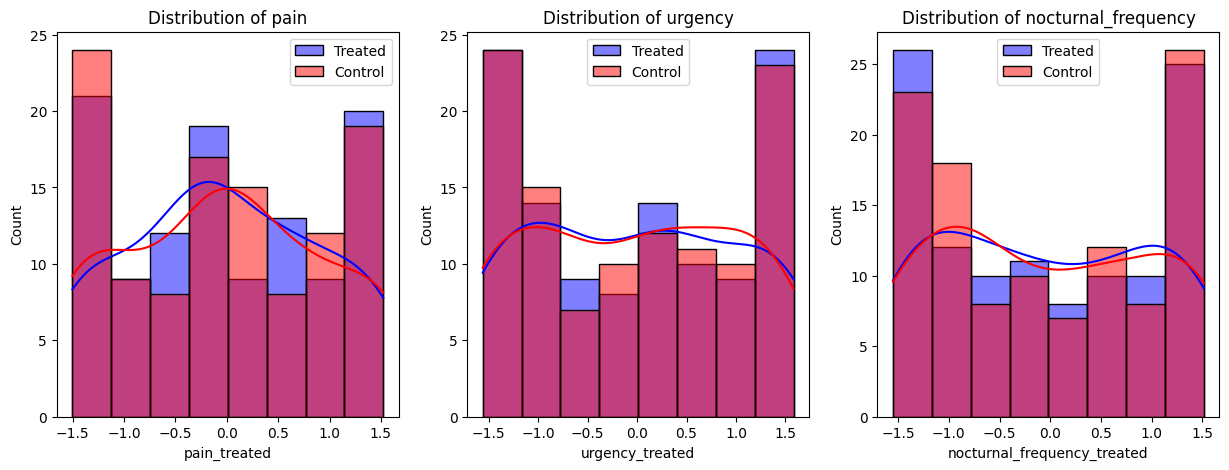

In [34]:
"""
We visualize symptom distributions before and after matching.
"""

# Merge matched patients' data
matched_data = matched_df.merge(patient_data, left_on='treated_patient', right_on='patient_id')
matched_data = matched_data.merge(patient_data, left_on='control_patient', right_on='patient_id', suffixes=('_treated', '_control'))

# Compare distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, symptom in enumerate(['pain', 'urgency', 'nocturnal_frequency']):
    sns.histplot(matched_data[f"{symptom}_treated"], color="blue", label="Treated", kde=True, ax=axes[i])
    sns.histplot(matched_data[f"{symptom}_control"], color="red", label="Control", kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {symptom}")
    axes[i].legend()

plt.show()

### Step 5: Sensitivity Analysis (Handling Hidden Bias)

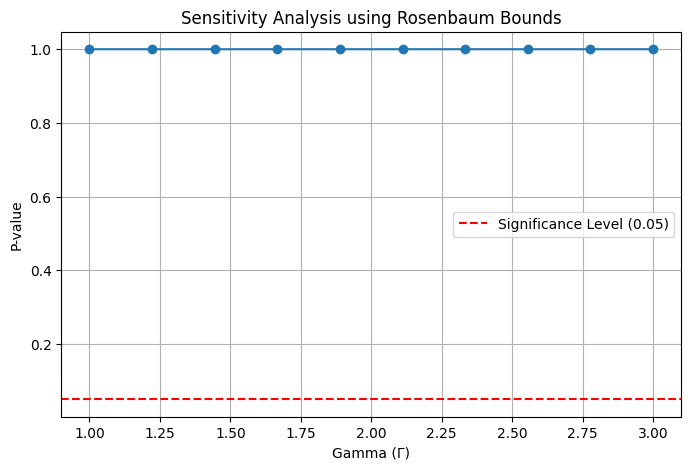

In [36]:
# 1. Introduce a Hidden Bias Variable
np.random.seed(42)
patient_data['hidden_bias'] = np.random.normal(0, 1, num_patients)

# Adjust treatment assignment based on hidden bias
patient_data['treated'] = np.where(
    patient_data['hidden_bias'] + np.random.logistic(0, 1, num_patients) > 0, 1, 0
)

# 2. Perform Matching
matched_pairs = []
for _, treated in patient_data[patient_data['treated'] == 1].iterrows():
    eligible_controls = patient_data[(patient_data['treated'] == 0) & 
                                     (patient_data['entry_time'] <= treated['treatment_time'])]
    if not eligible_controls.empty:
        distances = (eligible_controls[['pain', 'urgency', 'nocturnal_frequency']] - 
                     treated[['pain', 'urgency', 'nocturnal_frequency']].values).abs().sum(axis=1)
        best_match_idx = distances.idxmin()
        match = eligible_controls.loc[best_match_idx]
        matched_pairs.append((treated['patient_id'], match['patient_id']))

matched_df = pd.DataFrame(matched_pairs, columns=['treated_patient', 'control_patient'])

# 3. Sensitivity Analysis using Simplified Rosenbaum Bounds
def simple_rosenbaum_bounds(matched_df, patient_data, gamma=1.5):
    treated_outcomes = matched_df.merge(patient_data, left_on='treated_patient', right_on='patient_id')['pain']
    control_outcomes = matched_df.merge(patient_data, left_on='control_patient', right_on='patient_id')['pain']
    differences = treated_outcomes - control_outcomes
    
    num_positive = np.sum(differences > 0)
    num_total = len(differences)
    
    p_value_upper = norm.sf((num_positive - (gamma / (1 + gamma)) * num_total) / np.sqrt(num_total * gamma / (1 + gamma)**2))
    return p_value_upper

# Apply the Rosenbaum bounds for different gamma values
gamma_values = np.linspace(1, 3, 10)
p_values = [simple_rosenbaum_bounds(matched_df, patient_data, gamma) for gamma in gamma_values]

# 4. Visualize the Impact of Hidden Bias
plt.figure(figsize=(8, 5))
plt.plot(gamma_values, p_values, marker='o')
plt.axhline(0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Gamma (Γ)')
plt.ylabel('P-value')
plt.title('Sensitivity Analysis using Rosenbaum Bounds')
plt.legend()
plt.grid(True)
plt.show()